In [1]:
pip install yfinance

     ---------------------------------------- 0.0/315.3 kB ? eta -:--:--
     - -------------------------------------- 10.2/315.3 kB ? eta -:--:--
     ------- ------------------------------- 61.4/315.3 kB 1.7 MB/s eta 0:00:01
     ------------ ------------------------- 102.4/315.3 kB 1.2 MB/s eta 0:00:01
     ---------------------- --------------- 184.3/315.3 kB 1.4 MB/s eta 0:00:01
     ---------------------------------- --- 286.7/315.3 kB 1.6 MB/s eta 0:00:01
     -------------------------------------- 315.3/315.3 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ------------

In [2]:
import yfinance as yf

stock_symbol = 'AAPL'
start_date = '2023-04-01'
end_date = '2024-04-01'

stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data['Returns'] = stock_data['Close'].pct_change()

In [4]:
import numpy as np
from scipy.stats import norm

In [5]:
annual_volatility = stock_data['Returns'].std() * np.sqrt(252)

In [29]:
print("The annual volatility is : ", annual_volatility)

The annual volatility is :  0.1935719432079699


In [6]:
risk_free_rate = 0.05  

def binomial_option_price(S, K, T, r, sigma, option_type='call', n=100):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_tree = np.zeros((n + 1, n + 1))
    for j in range(n + 1):
        for i in range(j + 1):
            stock_tree[i, j] = S * (u ** (j - i)) * (d ** i)

    option_tree = np.zeros((n + 1, n + 1))
    if option_type == 'call':
        option_tree[:, n] = np.maximum(0, stock_tree[:, n] - K)
    else:
        option_tree[:, n] = np.maximum(0, K - stock_tree[:, n])

    for j in range(n - 1, -1, -1):
        for i in range(j + 1):
            option_tree[i, j] = np.exp(-r * dt) * (p * option_tree[i, j + 1] + (1 - p) * option_tree[i + 1, j + 1])

    return option_tree[0, 0]

In [7]:
def black_scholes_option_price(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return option_price

In [15]:
def verify_convergence(S, K, T, r, sigma, option_type='call'):
    steps = np.arange(10, 1000, 10)
    call_option_prices = []
    put_option_prices = []
    for n in steps:
        call_option_price = binomial_option_price(S, K, T, r, sigma, 'call', n)
        put_option_price = binomial_option_price(S, K, T, r, sigma, 'put', n)
        call_option_prices.append(call_option_price)
        put_option_prices.append(put_option_price)

    return steps, call_option_prices, put_option_prices


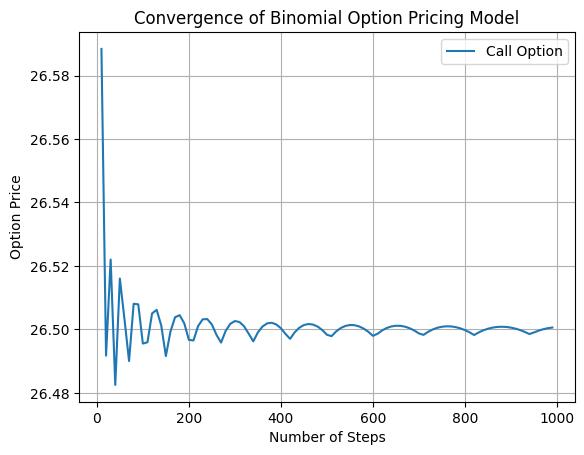

In [16]:
import matplotlib.pyplot as plt

S = stock_data['Close'].iloc[-1]
K = 150
T = 0.5

steps, call_option_prices, put_option_prices = verify_convergence(S, K, T, risk_free_rate, annual_volatility)

plt.plot(steps, call_option_prices, label='Call Option')
plt.xlabel('Number of Steps')
plt.ylabel('Option Price')
plt.title('Convergence of Binomial Option Pricing Model')
plt.legend()
plt.grid(True)
plt.show()


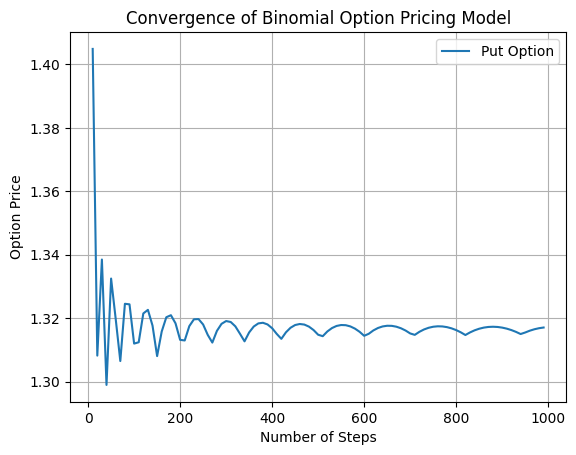

In [17]:
plt.plot(steps, put_option_prices, label='Put Option')
plt.xlabel('Number of Steps')
plt.ylabel('Option Price')
plt.title('Convergence of Binomial Option Pricing Model')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
print("The put price when the binomial option pricing model is used is : ", put_option_prices[0])
print("The call price when the binomial option pricing model is used is : ", call_option_prices[0])

The put price when the binomial option pricing model is used is :  1.4048790252179348
The call price when the binomial option pricing model is used is :  26.58838794850725


In [31]:
call_price = black_scholes_option_price(S, K, T, r=risk_free_rate, sigma=annual_volatility, option_type='call')
print("The Call price when the black scholes formula is used : ", call_price)

put_price = black_scholes_option_price(S, K, T, r=risk_free_rate, sigma=annual_volatility, option_type="put")
print("The Put price when the black scholes formula is used : ", put_price)

The Call price when the black scholes formula is used :  26.49986592344878
The Put price when the black scholes formula is used :  1.316357000159627


In [24]:
calculated_option_price_binomial = binomial_option_price(S, K, T, risk_free_rate, annual_volatility)
option_chain = yf.Ticker(stock_symbol).options

expiration_date = option_chain[0]

option_data = yf.Ticker(stock_symbol).option_chain(expiration_date)
call_option = option_data.calls[option_data.calls['strike'] == K]
actual_option_price = call_option['lastPrice'].iloc[0]

print(f'Calculated option price (Binomial Model): {calculated_option_price_binomial}')
print(f'Actual market price: {actual_option_price}')

Calculated option price (Binomial Model): 26.495513449243745
Actual market price: 17.15


In [20]:
def black_scholes_delta(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + ((r + 0.5 * sigma ** 2) * T)) / (sigma * np.sqrt(T))
    if option_type == 'call':
        delta = norm.cdf(d1)
    else:
        delta = norm.cdf(d1) - 1
    return delta

option_delta = black_scholes_delta(S, K, T, risk_free_rate, annual_volatility)

stock_units = option_delta
option_units = -1

In [25]:
from scipy.stats import norm

def black_scholes_vega(S, K, T, r, sigma, option_type='call'):
    d1 = ((np.log(S / K) + (r + 0.5 * sigma ** 2) * T)) / (sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return vega

def implied_volatility_newton(S, K, T, r, option_type, market_price, initial_guess=0.2, tol=1e-6, max_iter=3):
    sigma = initial_guess
    for _ in range(max_iter):
        option_price = black_scholes_option_price(S, K, T, r,sigma, option_type)
        vega = black_scholes_vega(S, K, T, r, sigma, option_type)
        if abs(option_price - market_price) < tol:
            break
        sigma -= (option_price - market_price) / vega
    return sigma

market_price_float = float(actual_option_price)
implied_volatility = implied_volatility_newton(S, K, T, risk_free_rate, 'call', market_price_float)
print(f'Implied volatility: {implied_volatility}')

Implied volatility: 0.010231182072694134
